In [ ]:
import datetime
from collections import defaultdict
import warnings
from scipy.optimize import minimize
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import ModelCheckpoint
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import Quote
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from stock_indicators.indicators.common.enums import PeriodSize
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import GARCH

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.6f}'.format)

In [ ]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

In [ ]:
funds_w_names = defaultdict(pd.DataFrame)

In [ ]:
etf_names = ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B5M4WH52','IE00B66F4759','EMBE.L', 'DTLE.L','IE00BDFK1573','IBC5.DE','IE00BFNM3G45','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
'IE00BLDGH553','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44','ISVIF', "IESE.AS", "UEEF.DE"]

In [ ]:
for fund in etf_names:
    print(fund)
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2023-01-03", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    a.index = a.index.normalize()
    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)

    a["Return"] = a["Close"].pct_change()
    a["Rolling Volatility"] = a["Return"].rolling(7).std()

    a.fillna(method="bfill", inplace=True)
    if fund != 'ISVIF':
        a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    else:
        a.drop(["Dividends", "Stock Splits"], inplace=True, axis=1)
    a.index = pd.to_datetime(a.index, utc=True)
    if a.index.hour[0] == 0:
        a.index = a.index + datetime.timedelta(hours=-1)
    a.index = a.index.normalize()

    a = a.sort_index()

    a["time_idx"] = (a.index - a.index.min()).days
    a["group_id"] = fund
    funds_w_names[fund] = a

In [ ]:
# pickle.dump(funds_w_names, open('funds_w_names.pkl', 'wb'))

In [ ]:
# import pickle
# pickle.dump(funds_w_names, open('funds_w_names_2.pkl', 'wb'))

In [ ]:
# funds_w_names = pd.read_pickle('funds_w_names_2.pkl')

In [ ]:
# def portfolio_factory(etfs: list):
#     #giga_fund = pd.DataFrame()
#     for c, ff in enumerate(etfs):
#         #f = ff.copy()
#
#         ff.index = pd.to_datetime(ff.index, utc=True)
#         if ff.index.hour[0]==0:
#             ff.index = ff.index+datetime.timedelta(hours=-1)
#         ff.index = ff.index.normalize()
#
#         ff = ff.sort_index()
#
#         ff["time_idx"] = (ff.index - ff.index.min()).days
#         ff["group_id"] = c
#         #f = f.reset_index()
#
#         #giga_fund = pd.concat([giga_fund, f], ignore_index=True)
#     #return giga_fund

In [ ]:
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):
        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in f.itertuples()]


        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)


        rsi_for_f = sa.indicators.get_rsi(quotes=quotes_for_f)
        valid_rsi_for_f = [
            (result.date, result.rsi)
            for result in rsi_for_f
            if result.date is not None and result.rsi is not None
        ]
        rsi_dates, rsi_values = zip(*valid_rsi_for_f)


        bb_for_f = sa.indicators.get_bollinger_bands(quotes=quotes_for_f)
        valid_bb_for_f = [
            (result.date, result.lower_band, result.upper_band)
            for result in bb_for_f
            if result.date is not None and result.lower_band is not None
        ]
        bb_dates, bb_lower, bb_upper = zip(*valid_bb_for_f)


        vwap_for_f = sa.indicators.get_vwap(quotes=quotes_for_f)
        valid_vwap_for_f = [
            (result.date, result.vwap)
            for result in vwap_for_f
            if result.date is not None and result.vwap is not None
        ]
        vwap_dates, vwap_values = zip(*valid_vwap_for_f)



        pp_for_f = sa.indicators.get_pivot_points(quotes=quotes_for_f, window_size=PeriodSize.DAY)
        valid_pp_for_f = [
            (result.date, result.pp, result.r1, result.r2, result.r3, result.r4, result.s1, result.s2, result.s3, result.s4)
            for result in pp_for_f
            if result.date is not None and result.pp is not None
        ]
        pp_dates, pp, r1, r2, r3, r4, s1, s2, s3, s4 = zip(*valid_pp_for_f)




        fig, axes = plt.subplots(5, 1, figsize=(12,12))


        axes[0].plot(macd_dates[-20:], macd_values[-20:], label='MACD_values', linewidth=2)
        axes[0].plot(macd_dates[-20:], macd_signal[-20:], label='MACD_signal', linewidth=2)
        axes[0].legend(loc='best')

        axes[1].plot(rsi_dates[-20:], rsi_values[-20:], label='RSI', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(bb_dates[-20:], bb_lower[-20:], label='BB_lower', linewidth=2)
        axes[2].plot(bb_dates[-20:], bb_upper[-20:], label='BB_upper', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(vwap_dates[-20:], vwap_values[-20:], label='vwap', linewidth=2)
        axes[3].legend(loc='best')

        axes[4].plot(pp_dates[-20:], pp[-20:], label='pivot points', linewidth=2)
        axes[4].plot(pp_dates[-20:], r1[-20:], label='r1', linewidth=2)
        axes[4].plot(pp_dates[-20:], r4[-20:], label='r4', linewidth=2)
        axes[4].plot(pp_dates[-20:], s1[-20:], label='s1', linewidth=2)
        axes[4].plot(pp_dates[-20:], s4[-20:], label='s4', linewidth=2)
        axes[4].legend(loc='best')


        figs.append(fig)

        f['Bullish'] = [1 if x.histogram and x.histogram > 0 else 0 for x in macd_for_f]
        f['Bearish'] = [1 if x.histogram and x.histogram < 0 else 0 for x in macd_for_f]
        f['isOverbought'] = [1 if x.rsi and x.rsi > 70 else 0 for x in rsi_for_f ]
        f['isOversold'] = [1 if x.rsi and x.rsi < 30 else 0 for x in rsi_for_f ]


        f.fillna(method="ffill", inplace=True)
        indicators_per_fund[names[id]]= f
    return indicators_per_fund, figs

In [96]:
def optuna(batch_size: int, df: pd.DataFrame, independent_variables: list, target="Close", training_cutoff_idx: pd.Timestamp=300, max_prediction_length=61, min_encoder_length=22):
    tablica_z_optymalnymi = []
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",  # Sequential time index
        target=target,  # Target variable
        group_ids=["group_id"],  # Group identifier
        min_encoder_length=min_encoder_length,  # Minimum input sequence length
        max_encoder_length=334,  # Maximum input sequence length
        min_prediction_length=1,  # Minimum forecast length
        max_prediction_length=max_prediction_length,  # Maximum forecast length (31 for December)
        static_categoricals=["group_id"],
        static_reals=[],  # No static real variables
        time_varying_known_reals=independent_variables,  # Known inputs
        time_varying_unknown_reals=[target],  # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,  # Add relative time index
        add_target_scales=True,  # Scale the target variable
        add_encoder_length=True,  # Include encoder length feature
        allow_missing_timesteps=False,  # Ensure no missing steps

    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True  # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=400,
        max_epochs=150,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(64, 256),
        hidden_continuous_size_range=(64, 256),
        attention_head_size_range=(2, 8),
        learning_rate_range=(0.001, 0.01),
        dropout_range=(0.05, 0.2),
        trainer_kwargs=dict(limit_train_batches=30),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    )

    tablica_z_optymalnymi.append(study.best_trial.params)
    return tablica_z_optymalnymi

In [97]:
def fit(gradient_clip, drop, hidden_size, hidden_continuous_size, attention_head_size, learning_rate, epochs: int, batch_size: int, df: pd.DataFrame, independent_variables: list, target="Close", training_cutoff_idx: pd.Timestamp=300, max_prediction_length=61, min_encoder_length=22):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",  # Sequential time index
        target=target,  # Target variable
        group_ids=["group_id"],  # Group identifier
        min_encoder_length=min_encoder_length,  # Minimum input sequence length
        max_encoder_length=334,  # Maximum input sequence length
        min_prediction_length=1,  # Minimum forecast length
        max_prediction_length=max_prediction_length,  # Maximum forecast length (31 for December)
        static_categoricals=["group_id"],
        static_reals=[],  # No static real variables
        time_varying_known_reals=independent_variables,  # Known inputs
        time_varying_unknown_reals=[target],  # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,  # Add relative time index
        add_target_scales=True,  # Scale the target variable
        add_encoder_length=True,  # Include encoder length feature
        allow_missing_timesteps=False,  # Ensure no missing steps

    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True  # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,  # Learning rate
        hidden_size=hidden_size,  # Model hidden size
        attention_head_size=attention_head_size,  # Number of attention heads
        dropout=drop,  # Dropout rate
        hidden_continuous_size=hidden_continuous_size,  # Hidden size for continuous variables
        output_size=7,  # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),  # Loss function
        log_interval=10,  # Log every 10 batches
        reduce_on_plateau_patience=4,  # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=8, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cuda',
        devices="auto",
        gradient_clip_val=gradient_clip,
        callbacks=[early_stop_callback, lr_logger],  #, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    return tft, training, val_dataloader

In [98]:
def predictt(tft, training, data):
    pred_data = TimeSeriesDataSet.from_dataset(
        dataset=training,
        data=data,
        predict=True,
        stop_randomization=True)

    pred_dataloader = pred_data.to_dataloader(train=False, batch_size=64 * 10, num_workers=0)

    raw_predictions = tft.predict(pred_dataloader, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [99]:
def huber_loss(actual_val, pred_val, delta=5.0):
    err = np.abs(actual_val - pred_val)
    return np.mean(np.where( err <= delta, 0.5 * err**2, delta * (err - 0.5 * delta)))

In [100]:
from decimal import Decimal
def relative_squared_error(true, pred):
    true = np.array([Decimal(float(x)) for x in true])
    pred = np.array([Decimal(float(x)) for x in pred])

    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

def relative_absolute_error(true, pred):
    true = np.array([Decimal(float(x)) for x in true])
    pred = np.array([Decimal(float(x)) for x in pred])
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.abs(true - pred))
    squared_error_den = np.sum(np.abs(true - true_mean))
    rae_loss = squared_error_num / squared_error_den
    return rae_loss

In [101]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range, target="Close", date = "2023-12-01"):
    print(len(df))
    print(len(preds))
    actual_values = df[target][date:]
    rse = relative_squared_error(actual_values, preds)
    rae = relative_absolute_error(actual_values, preds)
    huber = huber_loss(actual_values, preds)
    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label=f"Actual {target}", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for November 30th up to December 29th, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return rse, rae, huber, plt

BASELINE MODEL

In [ ]:
f1 = funds_w_names['EWSA.AS']["Close"][:-30]

In [ ]:
model = ARIMA(f1, order=(5, 2, 0))
model_fit = model.fit()
arima_forecast = model_fit.forecast(steps=30)
print("ARIMA Forecast for the next 30 periods:", arima_forecast)

In [ ]:
arima_rse = relative_squared_error(funds_w_names["EWSA.AS"]["Close"][-30:], arima_forecast)
arima_rae = relative_absolute_error(funds_w_names["EWSA.AS"]["Close"][-30:], arima_forecast)

In [ ]:
arima_rse

In [ ]:
sf = StatsForecast(models=[GARCH()], freq='D')
f1=pd.DataFrame(f1)
f1['ds'] = pd.to_datetime(f1.index)
f1.rename(columns={'Close': 'y'}, inplace=True)
f1['unique_id']=1

In [ ]:
garch_forecast = sf.forecast(h=30, df=f1)

print(garch_forecast)

In [ ]:
garch_rse = relative_squared_error(funds_w_names["EWSA.AS"]["Rolling Volatility"][-30:], garch_forecast["GARCH(1,1)"])
garch_rae = relative_absolute_error(funds_w_names["EWSA.AS"]["Rolling Volatility"][-30:], garch_forecast["GARCH(1,1)"])

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,6))


axes[0].plot(funds_w_names["EWSA.AS"][-30:].index, arima_forecast[-30:], label='arima_forecast', linewidth=2)
axes[0].plot(funds_w_names["EWSA.AS"][-30:].index, funds_w_names["EWSA.AS"]["Close"][-30:], label='Close', linewidth=2)
axes[0].legend(loc='best')
axes[1].plot(funds_w_names["EWSA.AS"][-30:].index, garch_forecast["GARCH(1,1)"], label='garch_forecast', linewidth=2)
axes[1].plot(funds_w_names["EWSA.AS"][-30:].index, funds_w_names["EWSA.AS"]["Rolling Volatility"][-30:], label='Volatility', linewidth=2)
axes[1].legend(loc='best')
plt.legend()
plt.show()

In [ ]:
test_funds = defaultdict(pd.DataFrame)
train_funds = defaultdict(pd.DataFrame)
for i in funds_w_names:
    test_funds[i] = funds_w_names[i][-62:]
    train_funds[i] = funds_w_names[i][:-62]
    #test_funds[i]= test_funds[i].drop('Close', axis=1)
    test_funds[i]["Close"] = 0.0
    test_funds[i].index = pd.to_datetime(test_funds[i].index)
    
    train_funds[i].index = pd.to_datetime(train_funds[i].index)
    test_funds[i]["time_idx"] = (test_funds[i].index - test_funds[i].index.min()).days
    train_funds[i]["time_idx"] = (train_funds[i].index - train_funds[i].index.min()).days

1) ONE FUND, NO INDICATORS, PRICE

In [ ]:
#IE00B52MJY50
#IE = portfolio_factory(etfs=[funds_w_names['EWSA.AS']])

In [ ]:
IE_tft, training, val = fit(epochs=100, batch_size=128, df=train_funds['EWSA.AS'], independent_variables=["Open", "High", "Low", "Volume"], drop=0.14, hidden_size=31, learning_rate=0.006, attention_head_size=4, gradient_clip=0.4, hidden_continuous_size=9, max_prediction_length=62, min_encoder_length=0)

In [ ]:
IE_preds = predictt(IE_tft, training, test_funds["EWSA.AS"])

In [ ]:
IE_rse, IE_rae, IE_huber, IE_plt = metrics_and_plt(funds_w_names['EWSA.AS'], IE_preds[-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [ ]:
IE_huber

2) ONE FUND, INDICATORS, PRICE

In [ ]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['EWSA.AS']], ['EWSA.AS'])

In [ ]:
analiza = IE_indicators["EWSA.AS"][["isOversold", "isOverbought", "Bullish", "Bearish", "Return"]]

In [ ]:
import seaborn as sns
corr1 = analiza.corr()
sns.heatmap(corr1, annot=True, cmap="coolwarm", fmt=".2f")

In [ ]:
test_funds_indic = defaultdict(pd.DataFrame)
train_funds_indic = defaultdict(pd.DataFrame)
for i in funds_w_names:
    test_funds_indic[i] = funds_w_names[i][-62:]
    train_funds_indic[i] = funds_w_names[i][:-62]

    test_funds_indic[i]["Close"] = 0.0
    test_funds_indic[i].index = pd.to_datetime(test_funds_indic[i].index)

    train_funds_indic[i].index = pd.to_datetime(train_funds_indic[i].index)
    test_funds_indic[i]["time_idx"] = (test_funds_indic[i].index - test_funds_indic[i].index.min()).days
    train_funds_indic[i]["time_idx"] = (train_funds_indic[i].index - train_funds_indic[i].index.min()).days

In [ ]:
IE_indicators_tft, training, val = fit(epochs=100, batch_size=128, df=train_funds_indic["EWSA.AS"], independent_variables=["Open", "High", "Low", "Volume", "isOverbought", "Bullish"],gradient_clip=0.02, drop=0.15, hidden_size=31, hidden_continuous_size=12, attention_head_size=4, learning_rate=0.006, max_prediction_length=62, min_encoder_length=0)

In [ ]:
IE_indicators_preds = predictt(IE_indicators_tft, training, test_funds_indic["EWSA.AS"])

In [ ]:
IE_indicators_rse, IE_indicators_rae, IE_indicators_huber, IE_indicators_plt2= metrics_and_plt(funds_w_names["EWSA.AS"], IE_indicators_preds[-30:], pd.date_range(start="2023-11-30", end="2023-12-29"), date="2023-11-29")

In [ ]:
IE_indicators_huber

In [ ]:
IE_indicators["EWSA.AS"]["Close"]["2023-10-31":"2023-11-29"]

3) ONE FUND, INDICATORS, RESIDUALS

In [ ]:
resztki = abs(IE_indicators_preds - IE_indicators["EWSA.AS"]["Close"]["2023-10-28":"2023-12-29"])

In [ ]:
df_scary = IE_indicators["EWSA.AS"][299:].copy()
df_scary["Remainders"] = resztki

In [ ]:
df_scary.index = pd.to_datetime(df_scary.index)  # ensure index is datetime if not already
df_scary["time_idx"] = (df_scary.index.date - df_scary.index.date[0]).astype("timedelta64[D]").astype(int)
df_scary['group_id'] = IE_indicators["EWSA.AS"]["group_id"]

In [ ]:
df_scary_test = df_scary[-31:]
df_scary_train = df_scary[:-31]

df_scary_test["Remainders"] = 0.0
df_scary_test["Close"] = 0.0
df_scary_test.index = pd.to_datetime(df_scary_test.index)

df_scary_train.index = pd.to_datetime(df_scary_train.index)
df_scary_test["time_idx"] = (df_scary_test.index - df_scary_test.index.min()).days
df_scary_train["time_idx"] = (df_scary_train.index - df_scary_train.index.min()).days

In [ ]:
IE_tft_rem, training, val = fit(epochs=100, batch_size=128, df=df_scary, independent_variables=["Open", "High", "Low", "Volume", "isOverbought", "Bullish"], target="Remainders", max_prediction_length=31, drop=0.14, hidden_size=31, learning_rate=0.006, attention_head_size=4, gradient_clip=0.4, hidden_continuous_size=9, min_encoder_length=0)

In [ ]:
IE_tft_rem_preds= predictt(IE_tft_rem, training, df_scary_test)

In [ ]:
IE_model2_rse, IE_model2_rae, IE_model2_huber, IE_model2_plt= metrics_and_plt(df_scary[30:], IE_tft_rem_preds, pd.date_range(start="2023-11-29", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
IE_model2_rse

In [ ]:
IE_model2_rae

In [ ]:
IE_model2_huber

In [ ]:
final_preds = IE_indicators_preds.copy()[-31:] + IE_tft_rem_preds

In [ ]:
IE_model2_final_rse, IE_model2_final_rae, IE_model2_final_huber, IE_model2_final_plt= metrics_and_plt(df_scary[30:], final_preds, pd.date_range(start="2023-11-29", end="2023-12-29"), target="Close", date="2023-11-28")

In [ ]:
IE_model2_final_rse
IE_model2_final_rae
IE_model2_final_huber

4) MANY FUNDS, INDICATORS, PRICE

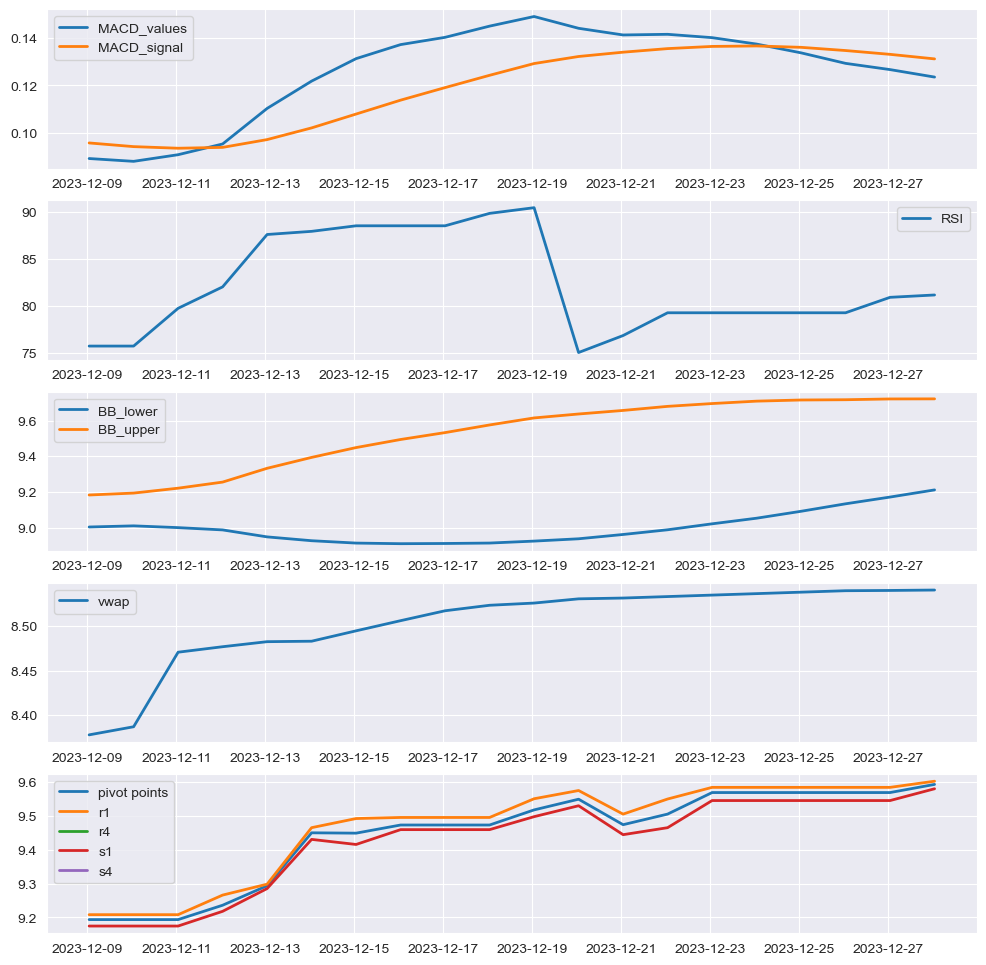

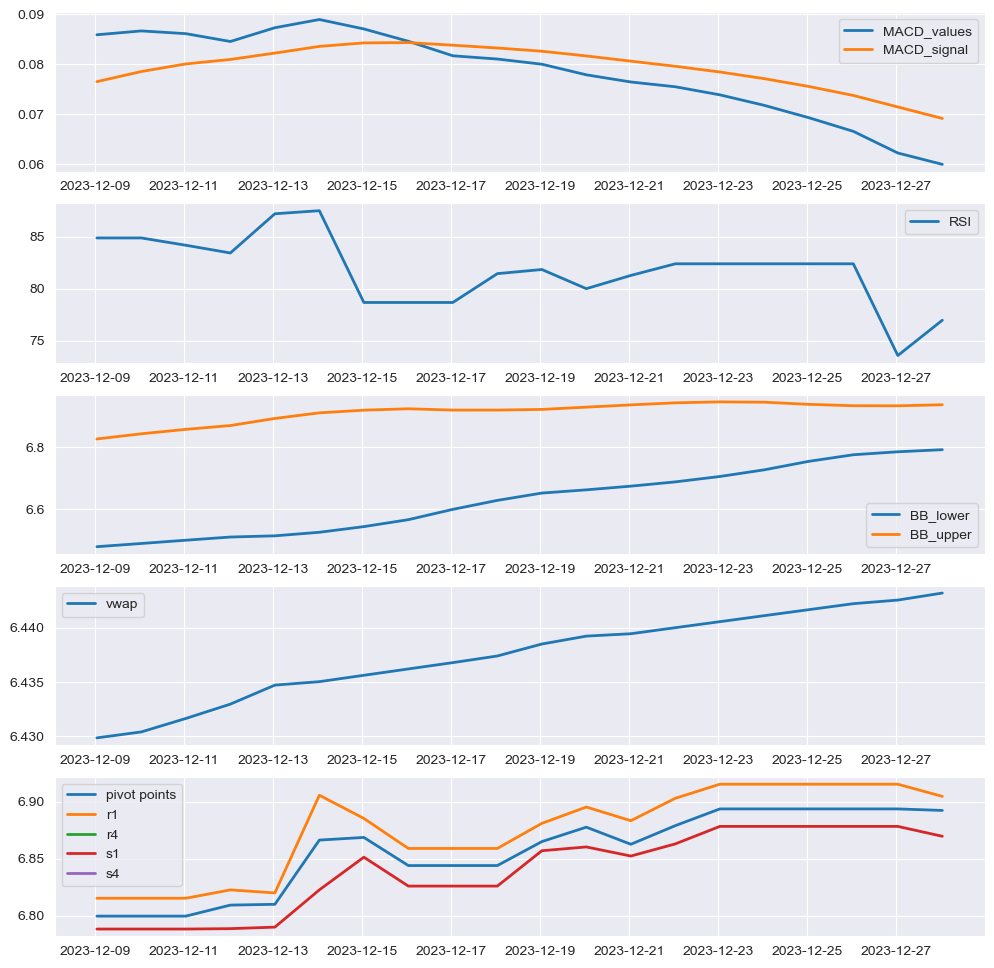

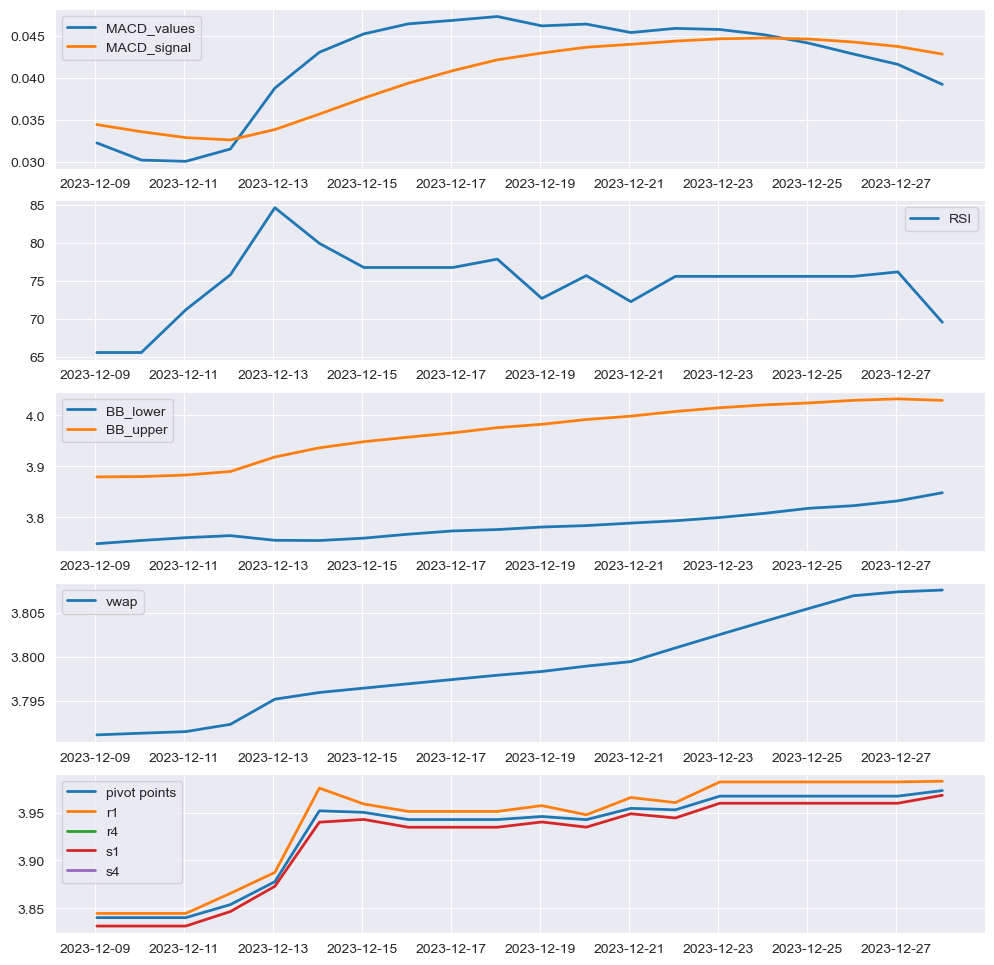

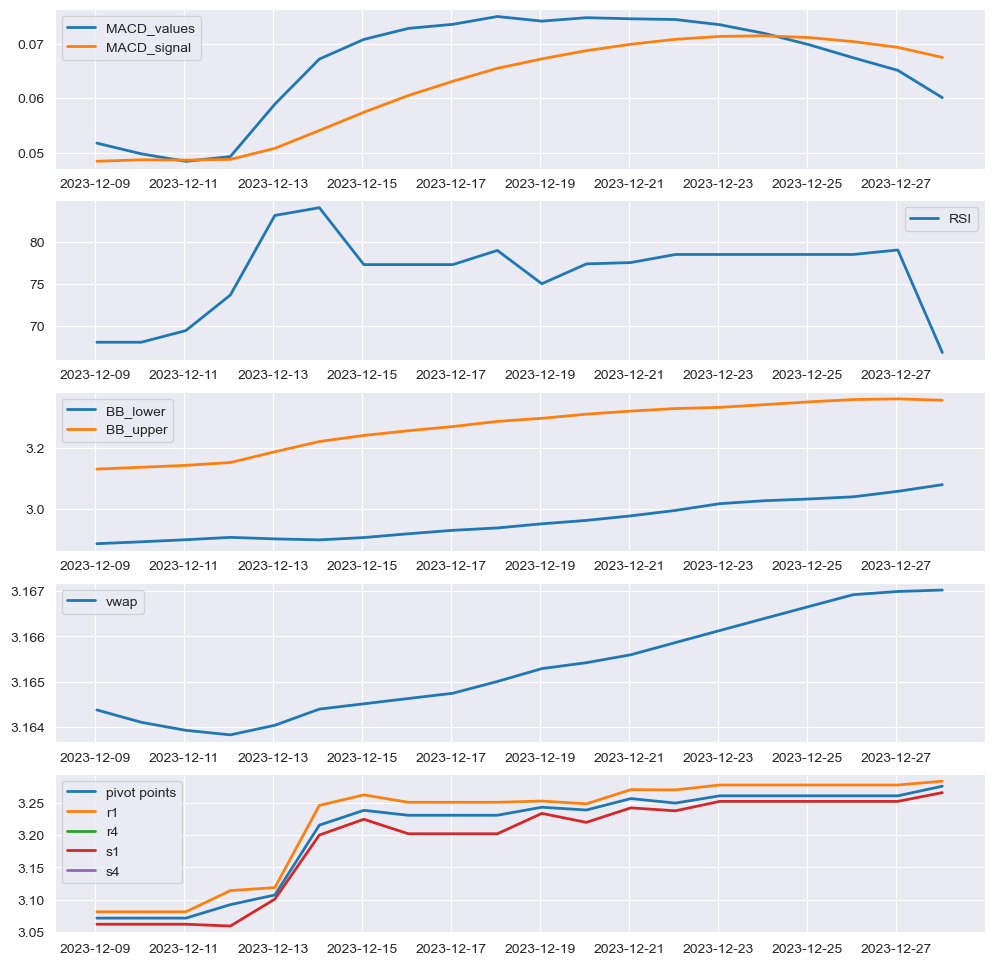

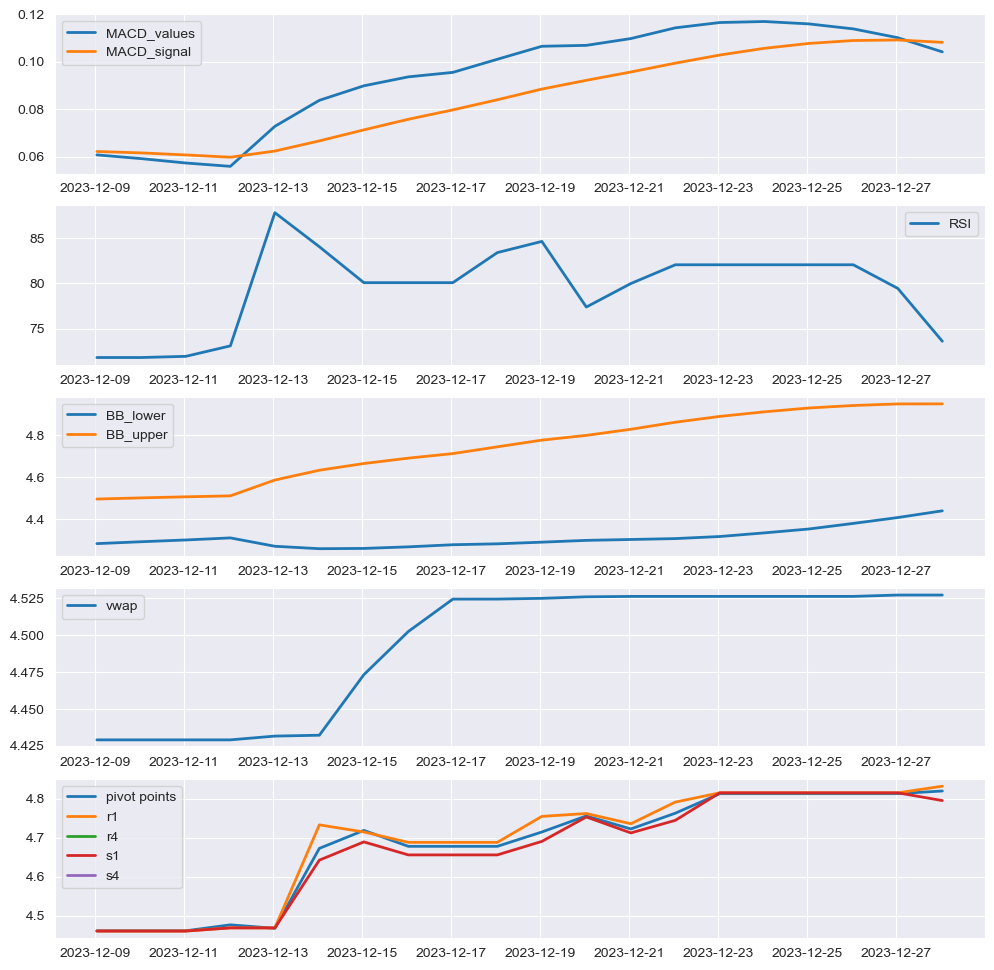

In [102]:
funds_for_hedge = ["IE00BFNM3G45", "IE00BHZPJ783", "36BA.DE", "DTLE.L", "EWSA.AS"]

dataframes_funds = []
for fund in funds_for_hedge:
    dataframes_funds.append(funds_w_names[fund])
fund_name_fund_df, sum_plt = technical_indicators_factory(dataframes_funds, funds_for_hedge)

In [103]:
test_funds_indic = defaultdict(pd.DataFrame)
train_funds_indic = defaultdict(pd.DataFrame)
for i in funds_w_names:
    test_funds_indic[i] = funds_w_names[i][-62:]
    train_funds_indic[i] = funds_w_names[i][:-62]
    #test_funds[i]= test_funds[i].drop('Close', axis=1)
    test_funds_indic[i]["Close"] = 0.0
    test_funds_indic[i].index = pd.to_datetime(test_funds_indic[i].index)

    train_funds_indic[i].index = pd.to_datetime(train_funds_indic[i].index)
    test_funds_indic[i]["time_idx"] = (test_funds_indic[i].index - test_funds_indic[i].index.min()).days
    train_funds_indic[i]["time_idx"] = (train_funds_indic[i].index - train_funds_indic[i].index.min()).days

In [104]:
dataframes_funds_test = []
dataframes_funds_train = []
dataframes_funds2 = []
for fund in funds_for_hedge:

    dataframes_funds_test.append(test_funds_indic[fund])
    dataframes_funds_train.append(train_funds_indic[fund])
# for fund in funds_for_hedge2:
#     dataframes_funds2.append(funds_w_names[fund].copy())

In [119]:
results = []
for i, f in enumerate(dataframes_funds_train):
    results.append(optuna(df=f, batch_size = 128, independent_variables=[], max_prediction_length =62, min_encoder_length=1, target="Close"))

[I 2025-02-14 20:43:17,596] A new study created in memory with name: no-name-0f9e04e9-7ce7-48ad-9256-af52aee5e0c3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=150` reached.
[I 2025-02-14 20:44:37,237] Trial 0 finished with value: 0.015606295317411423 and parameters: {'gradient_clip_val': 0.1280872399213631, 'hidden_size': 187, 'dropout': 0.14106938688311693, 'hidden_continuous_size': 94, 'attention_head_size': 2, 'learning_rate': 0.0041575988473286475}. Best is trial 0 with value: 0.015606295317411423.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=150` reached.
[I 2025-02-14 20:45:48,930] Trial 1 finished with value: 0.02338843233883381 and parameters: {'gradient_clip_val': 0.011852660258174127, 

In [ ]:
# best_params_per_model_REMAINDERS = [
#     {'gradient_clip_val': 0.9837710153630486, 'hidden_size': 31, 'dropout': 0.2350576066043487, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.015128183009392497},
#     {'gradient_clip_val': 0.023769508697715387, 'hidden_size': 29, 'dropout': 0.257857631364907, 'hidden_continuous_size': 29, 'attention_head_size': 3, 'learning_rate': 0.010048083399591495},
#     {'gradient_clip_val': 0.3097192385777495, 'hidden_size': 52, 'dropout': 0.12006384860557215, 'hidden_continuous_size': 23, 'attention_head_size': 3, 'learning_rate': 0.0042138867532417945},
#     {'gradient_clip_val': 0.01713316479279881, 'hidden_size': 41, 'dropout': 0.29028753651888917, 'hidden_continuous_size': 22, 'attention_head_size': 2, 'learning_rate': 0.010944731823071836},
#     {'gradient_clip_val': 0.1364092614065398, 'hidden_size': 59, 'dropout': 0.29882754959481694, 'hidden_continuous_size': 45, 'attention_head_size': 4, 'learning_rate': 0.0034770030794033604}]

In [ ]:
# best_params_per_model = [
#     {'gradient_clip_val': 0.1170917991042152, 'hidden_size': 60, 'dropout': 0.11869613309043395,
#      'hidden_continuous_size': 19, 'attention_head_size': 4, 'learning_rate': 0.003814810368668662},
#     {'gradient_clip_val': 0.015691176093369945, 'hidden_size': 98, 'dropout': 0.29590810356280955,
#      'hidden_continuous_size': 37, 'attention_head_size': 6, 'learning_rate': 0.005478633587765633},
#     {'gradient_clip_val': 0.032540265870562794, 'hidden_size': 75, 'dropout': 0.28617284712308855,
#      'hidden_continuous_size': 36, 'attention_head_size': 5, 'learning_rate': 0.005579041886792157},
#     {'gradient_clip_val': 0.27402792475271975, 'hidden_size': 14, 'dropout': 0.16937295209546838,
#      'hidden_continuous_size': 10, 'attention_head_size': 4, 'learning_rate': 0.007985354289781083},
#     {'gradient_clip_val': 0.11871482116616788, 'hidden_size': 62, 'dropout': 0.16547754484324415,
#      'hidden_continuous_size': 34, 'attention_head_size': 2, 'learning_rate': 0.0012659431875886532}
# ]

In [127]:
results[0][0]['gradient_clip_val']

0.12317360781364659

In [128]:
transformers=[]
vals=[]
trs=[]
for i, (params, fund) in enumerate(zip(results, dataframes_funds_train)):
    gradient_clip_val = params[0]['gradient_clip_val']
    hidden_size = params[0]['hidden_size']
    dropout = params[0]['dropout']
    hidden_continuous_size = params[0]['hidden_continuous_size']
    attention_head_size = params[0]['attention_head_size']
    learning_rate = params[0]['learning_rate']

    independent_variables = ["Open", "High", "Low", "Volume", "isOverbought", "Bullish"]

    tft, training, val = fit(
        gradient_clip=gradient_clip_val,
        hidden_size=hidden_size,
        drop=dropout,
        hidden_continuous_size=hidden_continuous_size,
        attention_head_size=attention_head_size,
        learning_rate=learning_rate,
        epochs=200,                # Or set it dynamically
        batch_size=128,            # Or set it dynamically
        df=fund,                   # Pass the fund data
        independent_variables=independent_variables,  # Pass independent variables
        min_encoder_length=0,
        max_prediction_length=62,
    )

    transformers.append(tft)
    vals.append(val)
    trs.append(training)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.6 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 82.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 223 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 194 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=170, train_loss_step=0.108]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=170, train_loss_step=0.0618, val_loss=0.0505, train_loss_epoch=0.228]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=170, train_loss_step=0.0483, val_loss=0.0583, train_loss_epoch=0.0789]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, v_num=170, train_loss_step=0.0385, val_loss=0.0427, train_loss_epoch=0.0524]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, v_num=170, train_loss_step=0.0314, val_loss=0.029, train_loss_epoch=0.0421] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, v_num=170, train_loss_step=0.0249, val_loss=0.0238, train_loss_epoch=0.0321]
Validation: |         

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.6 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 63.3 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 171 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 149 K  | train
7  | static_context_variable_selection  | GatedResidual

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  9.15it/s, v_num=171, train_loss_step=0.0494]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  9.57it/s, v_num=171, train_loss_step=0.0384, val_loss=0.0295, train_loss_epoch=0.0765]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s, v_num=171, train_loss_step=0.0212, val_loss=0.0284, train_loss_epoch=0.0327]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s, v_num=171, train_loss_step=0.0142, val_loss=0.0172, train_loss_epoch=0.023] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  9.09it/s, v_num=171, train_loss_step=0.0129, val_loss=0.0129, train_loss_epoch=0.017]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  9.78it/s, v_num=171, train_loss_step=0.0107, val_loss=0.011, train_loss_epoch=0.0131]
Validation: |         

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 2.7 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 228 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 612 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 534 K  | train
7  | static_context_variable_selection  | GatedResidual

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=172, train_loss_step=0.0222]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=172, train_loss_step=0.0164, val_loss=0.0194, train_loss_epoch=0.0402]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=172, train_loss_step=0.0117, val_loss=0.0128, train_loss_epoch=0.018] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=172, train_loss_step=0.00886, val_loss=0.0102, train_loss_epoch=0.0125]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=172, train_loss_step=0.00786, val_loss=0.00673, train_loss_epoch=0.00946]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=172, train_loss_step=0.00641, val_loss=0.00588, train_loss_epoch=0.00787]
Validation: |

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 2.5 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 190 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 512 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 447 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=173, train_loss_step=0.0579]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=173, train_loss_step=0.0416, val_loss=0.0438, train_loss_epoch=0.126]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=173, train_loss_step=0.0281, val_loss=0.038, train_loss_epoch=0.0446]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=173, train_loss_step=0.0223, val_loss=0.0306, train_loss_epoch=0.0302]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=173, train_loss_step=0.0198, val_loss=0.0162, train_loss_epoch=0.0241]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=173, train_loss_step=0.0146, val_loss=0.0124, train_loss_epoch=0.0193]
Validation: |         

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 2.0 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 114 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 308 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 268 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s, v_num=174, train_loss_step=0.0744]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=174, train_loss_step=0.0389, val_loss=0.051, train_loss_epoch=0.124]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=174, train_loss_step=0.0223, val_loss=0.0365, train_loss_epoch=0.0478]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, v_num=174, train_loss_step=0.0166, val_loss=0.022, train_loss_epoch=0.0273] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=174, train_loss_step=0.0172, val_loss=0.0217, train_loss_epoch=0.0187]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=174, train_loss_step=0.013, val_loss=0.0164, train_loss_epoch=0.0171] 
Validation: |         

In [129]:
pred = []
for i in range(len(dataframes_funds_test)):
    pred.append(predictt(transformers[i], trs[i], dataframes_funds_test[i]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [117]:
len(transformers)

1

In [ ]:
IE_many1_rse0, IE_many1_rae0, IE_many1_hub0, IE_many1_plt20,= metrics_and_plt(funds_w_names[funds_for_hedge[0]], pred[0][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [ ]:
IE_many1_rse0
IE_many1_rae0
IE_many1_hub0

In [ ]:
IE_many1_rse1, IE_many1_rae1, IE_many1_hub1, IE_many1_plt21,= metrics_and_plt(funds_w_names[funds_for_hedge[1]], pred[1][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [ ]:
IE_many1_rse1
IE_many1_rae1
IE_many1_hub1

In [ ]:
IE_many1_rse2, IE_many1_rae2, IE_many1_hub2, IE_many1_plt22,= metrics_and_plt(funds_w_names[funds_for_hedge[2]], pred[2][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [ ]:
IE_many1_rse2
IE_many1_rae2
IE_many1_hub2

In [ ]:
IE_many1_rse3, IE_many1_rae3, IE_many1_hub3, IE_many1_plt23,= metrics_and_plt(funds_w_names[funds_for_hedge[3]], pred[3][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [ ]:
IE_many1_rse3
IE_many1_rae3
IE_many1_hub3

In [ ]:
IE_many1_rse4, IE_many1_rae4, IE_many1_hub4, IE_many1_plt24,= metrics_and_plt(funds_w_names[funds_for_hedge[4]], pred[4][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [ ]:
IE_many1_rse4
IE_many1_rae4
IE_many1_hub4

5) MANY FUNDS, INDICATORS, RESIDUALS

In [130]:
resztkiii = []
for i in range(len(funds_for_hedge)):
    resztkiii.append(abs(pred[i] - fund_name_fund_df[funds_for_hedge[i]]["Close"]["2023-10-28":"2023-12-29"]))

In [131]:
residualsss=[]
residualsss_test= []
residualsss_train= []
for i in range(len(funds_for_hedge)):
    residualsss.append(funds_w_names[funds_for_hedge[i]][299:].copy())
    residualsss[i]["Remainders"] = resztkiii[i]
    residualsss_test.append(residualsss[i][-31:].copy())
    residualsss_train.append(residualsss[i][:-31].copy())
    residualsss_test[i]["Close"] = 0.0
    residualsss_test[i]["Remainders"] = 0.0
    residualsss_test[i].index = pd.to_datetime(residualsss_test[i].index)
    residualsss_train[i].index = pd.to_datetime(residualsss_train[i].index)
    
    residualsss_test[i]["time_idx"] = (residualsss_test[i].index - residualsss_test[i].index.min()).days.astype(int)
    residualsss_train[i]["time_idx"] = (residualsss_train[i].index - residualsss_train[i].index.min()).days.astype(int)

In [132]:
results_remainds = []
for i, f in enumerate(residualsss_train):
    results_remainds.append(optuna(df=f, batch_size = 128, independent_variables=[], max_prediction_length =30, min_encoder_length=1, target="Remainders"))

[I 2025-02-14 23:04:08,687] A new study created in memory with name: no-name-fcc5628f-4a8b-4517-a985-51ced7b7ad00
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=150` reached.
[I 2025-02-14 23:04:23,711] Trial 0 finished with value: 0.008682633750140667 and parameters: {'gradient_clip_val': 0.07364640372465574, 'hidden_size': 199, 'dropout': 0.18790716326749274, 'hidden_continuous_size': 189, 'attention_head_size': 4, 'learning_rate': 0.0016096795578090907}. Best is trial 0 with value: 0.008682633750140667.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=150` reached.
[I 2025-02-14 23:04:35,614] Trial 1 finished with value: 0.008345586247742176 and parameters: {'gradient_clip_val': 0.01651667817507717

In [133]:
transformers_res=[]
vals_res=[]
trs_res=[]
for i, (params, fund) in enumerate(zip(results_remainds, residualsss_train)):
    gradient_clip_val = params[0]['gradient_clip_val']
    hidden_size = params[0]['hidden_size']
    dropout = params[0]['dropout']
    hidden_continuous_size = params[0]['hidden_continuous_size']
    attention_head_size = params[0]['attention_head_size']
    learning_rate = params[0]['learning_rate']

    independent_variables = ["Open", "High", "Low", "Volume", "isOverbought", "Bullish"]

    tft, training, val = fit(
        # drop=0.14, hidden_size=31, learning_rate=0.006, attention_head_size=4, gradient_clip=0.4, hidden_continuous_size=9,
        gradient_clip=gradient_clip_val,
        hidden_size=hidden_size,
        drop=dropout,
        hidden_continuous_size=hidden_continuous_size,
        attention_head_size=attention_head_size,
        learning_rate=learning_rate,
        epochs=1000,                # Or set it dynamically
        batch_size=128,            # Or set it dynamically
        df=fund,                   # Pass the fund data
        independent_variables=independent_variables,  # Pass independent variables
        min_encoder_length=1,
        max_prediction_length=30,
        target="Remainders"
    )

    transformers_res.append(tft)
    vals_res.append(val)
    trs_res.append(training)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.7 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 70.5 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 190 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 166 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, v_num=180, train_loss_step=0.0314]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, v_num=180, train_loss_step=0.0197, val_loss=0.0198, train_loss_epoch=0.0314]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=180, train_loss_step=0.0162, val_loss=0.0162, train_loss_epoch=0.0197]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=180, train_loss_step=0.0139, val_loss=0.0139, train_loss_epoch=0.0162]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s, v_num=180, train_loss_step=0.0134, val_loss=0.0133, train_loss_epoch=0.0139]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=180, train_loss_step=0.0127, val_loss=0.0125, train_loss_epoch=0.0134]
Validation: |       

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.4 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 52.7 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 142 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 124 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=181, train_loss_step=0.0123]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=181, train_loss_step=0.00737, val_loss=0.00744, train_loss_epoch=0.0123]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=181, train_loss_step=0.00597, val_loss=0.00595, train_loss_epoch=0.00737]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=181, train_loss_step=0.0063, val_loss=0.00634, train_loss_epoch=0.00597] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s, v_num=181, train_loss_step=0.00586, val_loss=0.00589, train_loss_epoch=0.0063]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=181, train_loss_step=0.00573, val_loss=0.00566, train_loss_epoch=0.00586]
Validat

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 2.3 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 140 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 378 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 330 K  | train
7  | static_context_variable_selection  | GatedResidual

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s, v_num=182, train_loss_step=0.00436]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s, v_num=182, train_loss_step=0.00248, val_loss=0.00239, train_loss_epoch=0.00436]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=182, train_loss_step=0.0025, val_loss=0.00252, train_loss_epoch=0.00248] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=182, train_loss_step=0.00239, val_loss=0.00241, train_loss_epoch=0.0025]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s, v_num=182, train_loss_step=0.00234, val_loss=0.00232, train_loss_epoch=0.00239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s, v_num=182, train_loss_step=0.00218, val_loss=0.00217, train_loss_epoch=0.00234]
Valid

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.9 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 109 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 294 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 257 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s, v_num=183, train_loss_step=0.0307]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s, v_num=183, train_loss_step=0.0177, val_loss=0.0169, train_loss_epoch=0.0307]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s, v_num=183, train_loss_step=0.016, val_loss=0.0161, train_loss_epoch=0.0177] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s, v_num=183, train_loss_step=0.0137, val_loss=0.0133, train_loss_epoch=0.016]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s, v_num=183, train_loss_step=0.0128, val_loss=0.0124, train_loss_epoch=0.0137]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, v_num=183, train_loss_step=0.0114, val_loss=0.0109, train_loss_epoch=0.0128]
Validation: |        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.4 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 51.7 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 140 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 122 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s, v_num=184, train_loss_step=0.0352]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=184, train_loss_step=0.0176, val_loss=0.0169, train_loss_epoch=0.0352]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=184, train_loss_step=0.0178, val_loss=0.0181, train_loss_epoch=0.0176]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s, v_num=184, train_loss_step=0.0148, val_loss=0.0144, train_loss_epoch=0.0178]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s, v_num=184, train_loss_step=0.0152, val_loss=0.0155, train_loss_epoch=0.0148]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, v_num=184, train_loss_step=0.0144, val_loss=0.0139, train_loss_epoch=0.0152]
Validation: |       

In [134]:
res_preds_final = []
for i in range(len(funds_for_hedge)):
    res_preds_final.append(predictt(transformers_res[i], trs_res[i], residualsss_test[i]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


30
30


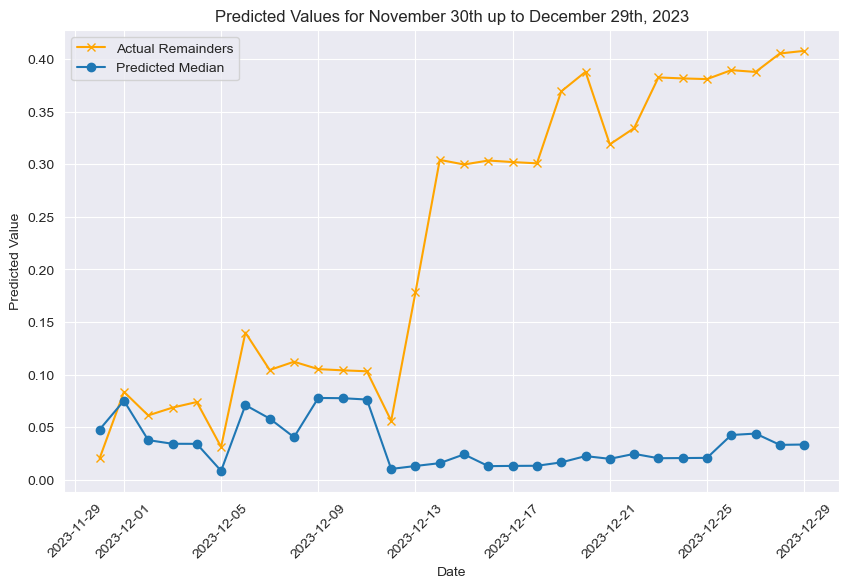

In [135]:
IE_many1_res_rse0, IE_many1_res_rae0, IE_many1_res_hube0, IE_many1_res_plt0 = metrics_and_plt(residualsss[0][-30:], res_preds[0],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
IE_many1_res_rse0
IE_many1_res_rae0
IE_many1_res_hube0

30
30


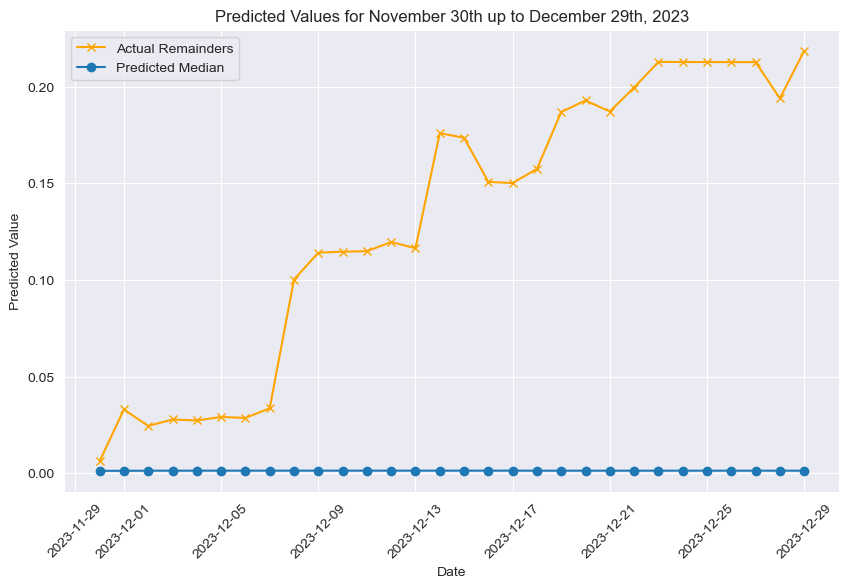

In [136]:
IE_many1_res_rse1, IE_many1_res_rae1, IE_many1_res_huber1, IE_many1_res_plt1 = metrics_and_plt(residualsss[1][-30:], res_preds[1],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [143]:
IE_many1_res_rse1
IE_many1_res_rae1
IE_many1_res_huber1

0.011053116389365123

30
30


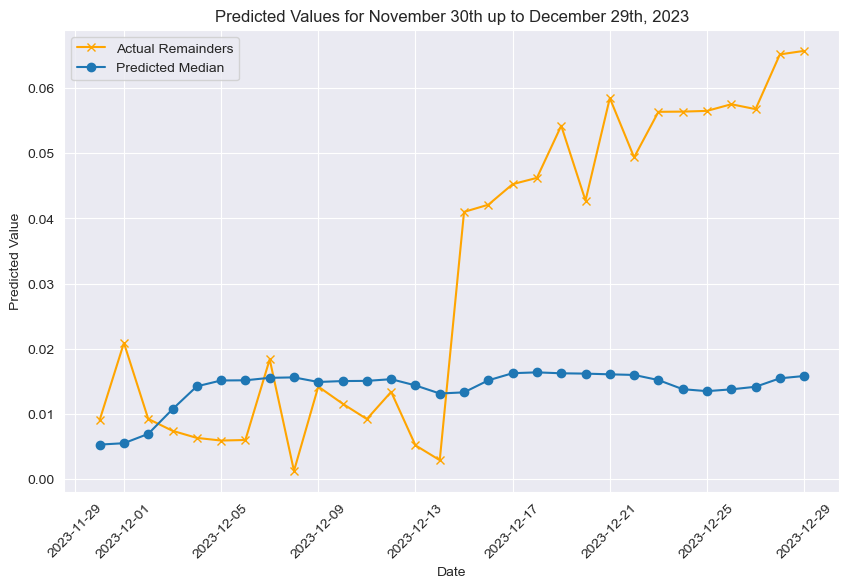

In [137]:
IE_many1_res_rse2, IE_many1_res_rae2, IE_many1_res_huber2, IE_many1_res_plt2 = metrics_and_plt(residualsss[2][-30:], res_preds[2],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [142]:
IE_many1_res_rse2
IE_many1_res_rae2
IE_many1_res_huber2

0.0003884552472862139

30
30


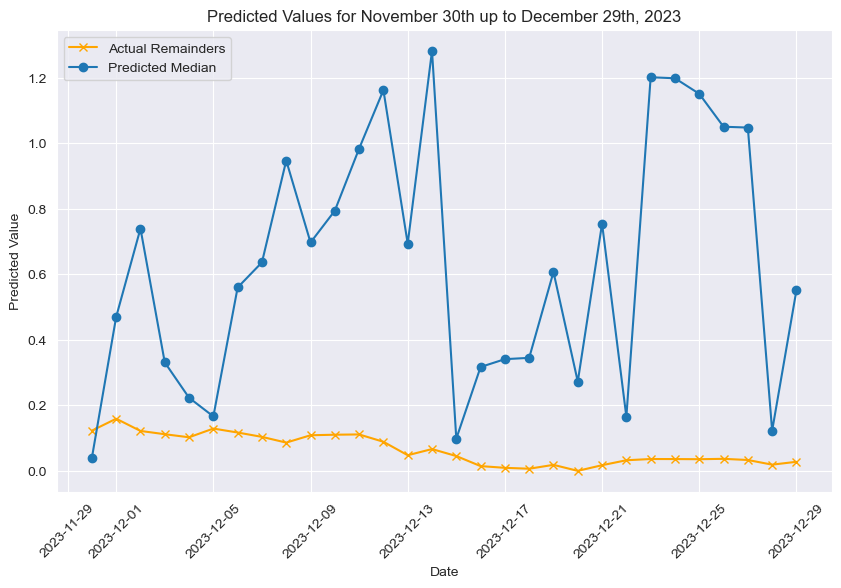

In [138]:
IE_many1_res_rse3, IE_many1_res_rae3, IE_many1_res_huber3, IE_many1_res_plt3 = metrics_and_plt(residualsss[3][-30:], res_preds[3],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [141]:
IE_many1_res_rse3
IE_many1_res_rae3
IE_many1_res_huber3

0.23286872940300024

30
30


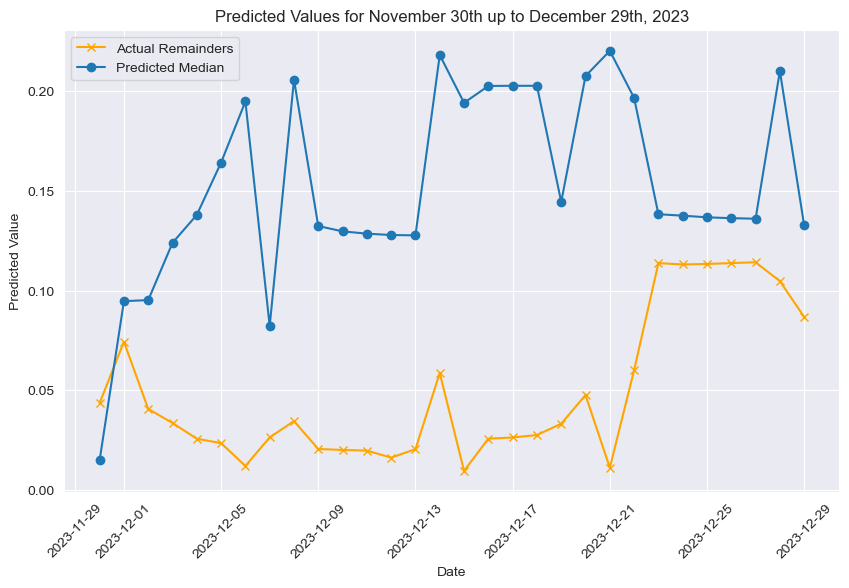

In [140]:
IE_many1_res_rse4, IE_many1_res_rae4, IE_many1_res_huber4, IE_many1_res_plt4 = metrics_and_plt(residualsss[4][-30:], res_preds[4],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [139]:
IE_many1_res_rse4
IE_many1_res_rae4
IE_many1_res_huber4

0.00692048420045433

6) FINAL RESULT PRICE + RESIDUALS

In [144]:
final_many_preds = []
for i in range(len(funds_for_hedge)):
    final_many_preds.append(pred[i].copy()[-30:] + res_preds[i])

30
30


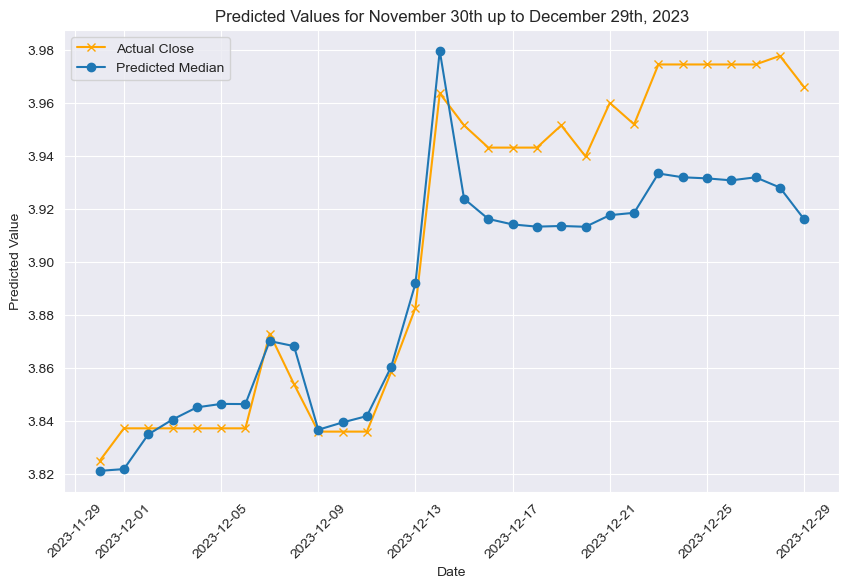

In [147]:
IE_final_many1_res_rse, IE_final_many1_res_rae, IE_final_many1_res_huber, IE_final_many1_res_plt = metrics_and_plt(funds_w_names[funds_for_hedge[2]][-30:], final_many_preds[2],pd.date_range(start="2023-11-30", end="2023-12-29"), target="Close", date="2023-11-28")

MONTER CARLOS PREDICTING RISK

In [155]:
def calc_drift(fund):
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    avg_pdr = log_returns.mean()
    var = log_returns.var()
    drift = avg_pdr-(.5*var)

    return drift

In [156]:
def monte_carlo_sim(fund):
    drift = calc_drift(fund)
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    stdev=log_returns.std()
    days=361
    trials=100
    Z = norm.ppf(np.random.rand(days,trials))
    daily_returns=np.exp(np.array(drift) + np.array(stdev) * Z)
    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = fund["Close"].iloc[-1]
    for i in range(1,days):
        price_paths[i] = price_paths[i-1] * daily_returns[i]
    return price_paths

In [157]:
drifts = calc_drift(funds_w_names["EWSA.AS"])
pp = monte_carlo_sim(funds_w_names["EWSA.AS"])

In [158]:
def volatility_mc(price_paths: pd.DataFrame):
    pp_df = pd.DataFrame(price_paths)
    pp_df= pp_df.pct_change()
    pp_df.fillna(value=0, inplace=True)
    pp_df=pp_df.rolling(7).std()
    pp_df.fillna(method="bfill", inplace=True)
    return pp_df.mean(axis=1)

In [159]:
simv = volatility_mc(pp)

monte carlo metrics

In [160]:
m = mean_squared_error(funds_w_names["EWSA.AS"]["Rolling Volatility"], simv)
print(f"MSE: {m}")

MSE: 1.6592471319657534e-05


In [161]:
sample_variance = np.var(simv, ddof=1)
print(f"Sample Variance: {sample_variance}")

Sample Variance: 5.4671273203649926e-08


In [162]:
n = len(simv)
half_n = n // 2

std_n = np.std(simv)
std_half_n = np.std(simv[:half_n])

convergence_factor = std_half_n / std_n
print(f"Convergence Factor: {convergence_factor}")

Convergence Factor: 1.1128858997048154


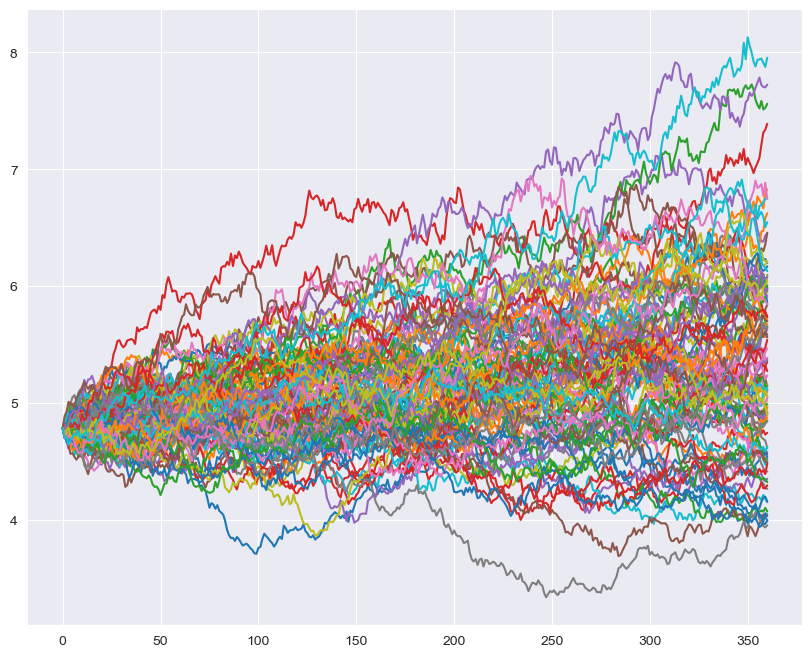

In [163]:
plt.figure(figsize=(10, 8))
plt.plot(pp)

Volatility tft

In [ ]:
IE_vol_tft, training, val = fit(epochs=100, batch_size=128, df=train_funds_indic["EWSA.AS"],
                                       independent_variables=["Open", "High", "Low", "Volume", "isOverbought",
                                                              "Bullish"], gradient_clip=0.02, drop=0.15, hidden_size=31,
                                       hidden_continuous_size=12, attention_head_size=4, learning_rate=0.006,
                                       max_prediction_length=62, min_encoder_length=0, target="Rolling Volatility")

In [ ]:
test_vol_EWSA = test_funds_indic["EWSA.AS"].copy()

In [ ]:
IE_vol_preds = predictt(IE_vol_tft, training, test_vol_EWSA)

In [ ]:
IE_vol_rse, IE_vol_rae, IE_vol_huber, IE_vol_plt2 = metrics_and_plt(
    funds_w_names["EWSA.AS"], IE_vol_preds[-30:], pd.date_range(start="2023-11-30", end="2023-12-29"),
    date="2023-11-29", target="Rolling Volatility")

In [ ]:
mean_squared_error(funds_w_names["EWSA.AS"]["Rolling Volatility"][-62:], IE_vol_preds)

TEZ DO KOSZA

In [ ]:
# list_of_5_df_funds = []

In [ ]:
# def nearest_positive_definite(matrix):
#     P = matrix.copy()
#     eigvals, eigvecs = np.linalg.eigh(P)
#     eigvals[eigvals < 0] = 1e-10
#     return eigvecs @ np.diag(eigvals) @ eigvecs.T

In [ ]:
# variances = {}
# covs_means = []
# for k,v in funds_w_names.items():
#     variances[k] = v["Rolling Volatility"]
# variances = pd.DataFrame(variances)
# r = variances.pct_change()
# covariance_matrix = r.cov()
# mean_returns = r.mean()

In [ ]:
# if not np.all(np.linalg.eigvals(covariance_matrix) > 0):
#     print("Covariance matrix not positive definite. Adding regularization.")
#     covariance_matrix = nearest_positive_definite(covariance_matrix)

In [ ]:
# #to be filled with real data
# portfolio_weights = np.random.random(len(mean_returns)) # distribution of etfs in portfolio
# portfolio_weights /= np.sum(portfolio_weights)

In [ ]:
# initial_portfoloio = 0
# for i, v in enumerate(funds_w_names.values()):
#     initial_portfoloio += portfolio_weights[i] * v["Close"][i]

In [ ]:
# days = 60
# simulations = 100
# portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0) # default
# mean_matrix = np.full(shape=(days, len(portfolio_weights)), fill_value=mean_returns).T # days x all etfs

In [ ]:
# for s in range(0, simulations):
#     Z = np.random.normal(size=(days, len(portfolio_weights)))
#     L = np.linalg.cholesky(covariance_matrix)
#     daily_returns = mean_matrix + np.inner(L, Z)
#     portfolio_sims[:, s] = np.cumprod(np.inner(portfolio_weights, daily_returns.T)+1)*initial_portfoloio
#
# plt.plot(portfolio_sims)
# plt.ylabel("Portfolio Simulations")

expected volatility

In [ ]:
# portfolio_returns = portfolio_sims[-1] / portfolio_sims[0] - 1  # final value over initial value gives portfolio returns
# portfolio_volatility = np.std(portfolio_returns)
# print(f"Portfolio Volatility: {portfolio_volatility:.4f}")

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(portfolio_sims)
# plt.title("Monte Carlo Simulations of Portfolio Value")
# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.show()

expected return

In [ ]:
# discounted_prices = [sim[-1]*0.96 for sim in portfolio_sims]

In [ ]:
# avg = np.average(discounted_prices)

MONTE CARLO EVALUATION FUNCITON

In [ ]:
# def test_robustness(paths, num_trials, tol=0.01):
#     means = []
#     for i in range(num_trials):
#         np.random.seed(i)
#         new_paths = np.random.choice(paths, size=len(paths), replace=True)
#         means.append(np.mean(new_paths))
#     glob_mean = np.mean(means)
#     devs = np.abs(np.array(means) - glob_mean)
#     return max(0, 1 - (np.mean(devs) / (tol*glob_mean)))

In [ ]:
# def compute_convergence_rate(paths, true_val):
#     cum_means = np.cumsum(paths)/np.arange(1, len(paths)+1)
#     difs = np.abs(cum_means - true_val)
#     final = difs[-1]
#     avg = np.mean(difs)
#     if avg == 0.0:
#         return 1.0
#     return max(0, 1-(final/avg))

In [ ]:
# def rate_mc_simulation(paths, true_value, runtime, weights):
#     mean_estimate = np.mean(paths)
#     variance = np.var(paths)
#     bias = mean_estimate - np.mean(true_value)
#     mse = bias**2 + variance
#     efficiency = 1 / (runtime * mse)
#
#     robustness = test_robustness(paths.mean(axis=1), 150)
#
#     convergence_rate = compute_convergence_rate(paths.mean(axis=1), true_value)
#
#     score = (
#             weights[0] * convergence_rate +
#             weights[1] * (1 / np.std(paths)) +
#             weights[2] * (1 / abs(bias)) +
#             weights[3] * (1 / variance) +
#             weights[4] * efficiency +
#             weights[5] * robustness)
#     return score

In [ ]:
# weights=[1/6,1/6,1/6,1/6,1/6,1/6]
# pd.Series(pp['EWSA.AS'].mean(axis=1))

REDESIGN PORTFOLIO

In [ ]:
'''
list of predictions for each fund in portfolio
'''
final_many_preds

In [148]:
'''
calculate ratio of a single fund based on provided predictions
'''
def calculate_funds_ratio(funds_preds, fund: pd.DataFrame):
    funds_return = fund["Close"].iloc[-62] - funds_preds[-1]
    funds_risk = np.mean(volatility_mc(monte_carlo_sim(fund)))
    data = yf.Ticker("^TNX").history(period="1d")
    risk_free_rate = data['Close'].iloc[-1] / 100
    sharpe_ratio = (funds_return - risk_free_rate) / funds_risk
    return sharpe_ratio, funds_return

In [149]:
def redistribute_funds(funds_dfs:list, weights: list):
    """
    for a given portfolio, calculate risk and return for next month for each asset and decide whether to buy more of it
    funds_dfs is a list of funds dataframes based on portfolio
    weights is a list of weights for each funds
    """

    def objective(w):
        portfolio_score = sum(
            w[i] * calculate_funds_ratio(final_many_preds[i], funds_w_names[funds_dfs[i]])[0]
            for i in range(len(funds_dfs))
        )
        return -portfolio_score

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0,1)] * len(funds_dfs)
    result = minimize(objective, weights, method='CG', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    optimized_score = result.fun

    returns = [calculate_funds_ratio(final_many_preds[i], funds_w_names[funds_dfs[i]])[1] for i in range(len(funds_for_hedge))]
    final_gain = np.dot(optimized_weights,returns)

    return optimized_weights, optimized_score, final_gain

In [ ]:
better_weights, better_score, final_gain = redistribute_funds(funds_for_hedge, [0.4,0.1,0.1,0.1,0.3])
print(f"Final Gain: {final_gain}\nBetter Score: {better_score}\nBetter Weights: {better_weights}\n")

In [150]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf

def calculate_expected_returns_and_mc_risk(funds_dfs, funds_preds):

    expected_returns = []
    mc_risks = []

    for i, fund in enumerate(funds_dfs):

        last_close = funds_w_names[fund]['Close'].iloc[-62]
        predicted_close = funds_preds[i][-1]
        predicted_return = (predicted_close - last_close) / last_close
        expected_returns.append(predicted_return)

        mc_volatility = np.mean(volatility_mc(monte_carlo_sim(funds_w_names[fund])))
        mc_risks.append(mc_volatility)


    expected_returns = np.array(expected_returns)
    mc_risks = np.array(mc_risks)


    return expected_returns, mc_risks

def objective(weights, expected_returns, mc_risks, lambda_risk_aversion):

    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.dot(weights, mc_risks)


    return lambda_risk_aversion * portfolio_risk - (1 - lambda_risk_aversion) * portfolio_return

def redistribute_funds_mc(funds_dfs, funds_preds, weights, lambda_risk_aversion=0.5):

    expected_returns, mc_risks = calculate_expected_returns_and_mc_risk(funds_dfs, funds_preds)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(funds_dfs)


    result = minimize(objective, weights, args=(expected_returns, mc_risks, lambda_risk_aversion),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed:", result.message)

    optimized_weights = result.x
    optimized_score = -result.fun


    final_return = np.dot(optimized_weights, expected_returns)
    final_risk = np.dot(optimized_weights, mc_risks)


    return optimized_weights, optimized_score, final_return, final_risk

In [154]:
lambda_risk_aversion = 0.22
better_weights, better_score, final_return, final_risk = redistribute_funds_mc(
    funds_for_hedge,
    final_many_preds,
    [0.4, 0.1, 0.1, 0.1, 0.3],
    lambda_risk_aversion
)

print(f"Final Return: {final_return}\nFinal Risk: {final_risk}\nBetter Weights: {better_weights}\n")

Final Return: 0.3827418320153064
Final Risk: 0.00831948686347423
Better Weights: [8.81299624e-16 2.44506653e-16 2.04112685e-16 1.00000000e+00
 0.00000000e+00]



In [ ]:
# import random
# from scipy.optimize import minimize
# from itertools import combinations
#
# def calculate_fitness(preds_for_selected_funds, funds_dfs, weights):
#     portfolio_score = 0
#     for i in range(len(funds_dfs)):
#         ratio, returnn, _ = calculate_funds_ratio(preds_for_selected_funds[i], funds_dfs[i])
#         portfolio_score += ratio * weights[i]
#     return portfolio_score
#
# def genetic_algorithm(funds_w_names, N, population_size=50, generations=100, mutation_rate=0.1, crossover_rate=0.8):
#     available_funds = list(funds_w_names.keys())
#     fund_combinations = list(combinations(available_funds, N))
#
#     population = []
#     for _ in range(population_size):
#         selected_funds = random.sample(fund_combinations, 1)[0]
#         weights = np.random.rand(N)
#         weights /= np.sum(weights)
#         population.append((selected_funds, weights))
#
#     best_solution = None
#     best_fitness = -np.inf
#
#     for generation in range(generations):
#         fitness_scores = []
#         preds_for_selected_funds_list = []
#         funds_dfs_list = []
#
#         for selected_funds, _ in population:
#             funds_dfs = [funds_w_names[fund] for fund in selected_funds]
#             preds_for_selected_funds = []
#             for fund in selected_funds:
#                 preds_for_selected_funds.append(predictt(29, funds_w_names[fund]))
#             preds_for_selected_funds_list.append(preds_for_selected_funds)
#             funds_dfs_list.append(funds_dfs)
#
#         for i in range(population_size):
#             selected_funds, weights = population[i]
#             fitness = calculate_fitness(preds_for_selected_funds_list[i], funds_dfs_list[i], weights)
#             fitness_scores.append(fitness)
#             if fitness > best_fitness:
#                 best_fitness = fitness
#                 best_solution = (selected_funds, weights)
#
#         selected_parents = []
#         fitness_sum = np.sum(fitness_scores)
#         prob = [score / fitness_sum for score in fitness_scores]
#
#         for _ in range(population_size):
#             selected_parent = random.choices(population, prob)[0]
#             selected_parents.append(selected_parent)
#
#         new_population = []
#         for i in range(0, population_size, 2):
#             parent1, parent2 = selected_parents[i], selected_parents[i+1]
#             if random.random() < crossover_rate:
#                 crossover_point = random.randint(1, N-1)  # Crossover at a random point
#                 offspring1 = (parent1[0][:crossover_point] + parent2[0][crossover_point:],
#                               np.concatenate((parent1[1][:crossover_point], parent2[1][crossover_point:])))
#                 offspring2 = (parent2[0][:crossover_point] + parent1[0][crossover_point:],
#                               np.concatenate((parent2[1][:crossover_point], parent1[1][crossover_point:])))
#                 new_population.extend([offspring1, offspring2])
#             else:
#                 new_population.extend([parent1, parent2])
#
#         for i in range(population_size):
#             if random.random() < mutation_rate:
#                 selected_funds, weights = new_population[i]
#                 mutation_idx = random.randint(0, N-1)
#                 weights[mutation_idx] = random.random()
#                 weights /= np.sum(weights)  # Normalize weights to sum to 1
#                 new_population[i] = (selected_funds, weights)
#
#         population = new_population
#
#     return best_solution, best_fitness

In [ ]:
# N = 5
# best_solution, best_fitness = genetic_algorithm(funds_w_names, N)
#
# selected_funds, optimized_weights = best_solution
# print("Selected funds:", selected_funds)
# print("Optimized weights:", optimized_weights)
# print("Best fitness (risk-adjusted return):", best_fitness)